In [1]:
from imutils import paths
import numpy as np
import cv2
import os
import tensorflow as tf
from keras.utils import img_to_array
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/first-image-classifier/first-image-classifier.zip
!unzip -qq first-image-classifier.zip
%cd first-image-classifier

--2023-06-10 14:00:45--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/first-image-classifier/first-image-classifier.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.92.242.170, 52.218.192.169, 52.92.240.50, ...
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.92.242.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196971354 (188M) [application/zip]
Saving to: ‘first-image-classifier.zip’

first-image-classif 100%[===================>] 187.85M  44.1MB/s    in 4.7s    

2023-06-10 14:00:50 (39.7 MB/s) - ‘first-image-classifier.zip’ saved [196971354/196971354]

/content/first-image-classifier


In [3]:
class SimplePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		# store the target image width, height, and interpolation
		# method used when resizing
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		# resize the image to a fixed size, ignoring the aspect
		# ratio
		return cv2.resize(image, (self.width, self.height),
			interpolation=self.inter)

In [4]:
class SimpleDatasetLoader:
	def __init__(self, preprocessors=None):
		# store the image preprocessor
		self.preprocessors = preprocessors

		# if the preprocessors are None, initialize them as an
		# empty list
		if self.preprocessors is None:
			self.preprocessors = []

	def load(self, imagePaths, verbose=-1):
		# initialize the list of features and labels
		data = []
		labels = []

		# loop over the input images
		for (i, imagePath) in enumerate(imagePaths):
			# load the image and extract the class label assuming
			# that our path has the following format:
			# /path/to/dataset/{class}/{image}.jpg
			image = cv2.imread(imagePath)
			label = imagePath.split(os.path.sep)[-2]

            # check to see if our preprocessors are not None
			if self.preprocessors is not None:
				# loop over the preprocessors and apply each to
				# the image
				for p in self.preprocessors:
					image = p.preprocess(image)

			# treat our processed image as a "feature vector"
			# by updating the data list followed by the labels
			data.append(image)
			labels.append(label)
   
			# show an update every `verbose` images
			if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
				print("[INFO] processed {}/{}".format(i + 1,
					len(imagePaths)))

		# return a tuple of the data and labels
		return (np.array(data), np.array(labels))

In [5]:
class ImageToArrayPreprocessor:
  def __init__(self,dataFormat=None):
    self.dataFormat = dataFormat

  def preprocess(self,image):
    return img_to_array(image,data_format=self.dataFormat)

In [6]:
# sp = SimplePreprocessor(32,32)
# iap = ImageToArrayProcessor()
# sdl = SimpleDatasetLoader(preprocessors=[sp,iap])


In [7]:
class ShallowNet:
  def build(width,height,depth,classes):
    
    # initialize the model along with the input shape to be "channels last"
    model = Sequential()
    inputShape = (height,width,depth)

    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)

    # define the CONV => RELU layer
    model.add(Conv2D(32,3,padding='same',input_shape=inputShape))
    model.add(Activation('relu'))
    model.add(Conv2D(64,3,padding='same'))
    model.add(Activation('relu'))
    #softmax classifier
    model.add(Flatten())
    model.add(Dense(classes))
    model.add(Activation('softmax'))

    #return the constructed network architecture
    return model

In [8]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("/content/first-image-classifier/dataset/animals"))
# initialize the image preprocessors
sp = SimplePreprocessor(32, 32)
iap = ImageToArrayPreprocessor()
# load the dataset from disk then scale the raw pixel intensities
# to the range [0, 1]
sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
(data, labels) = sdl.load(imagePaths, verbose=500)
data = data.astype("float") / 255.0

[INFO] loading images...
[INFO] processed 500/3000
[INFO] processed 1000/3000
[INFO] processed 1500/3000
[INFO] processed 2000/3000
[INFO] processed 2500/3000
[INFO] processed 3000/3000


In [9]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
test_size=0.20, random_state=42)

# convert the labels from integers to vectors
trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

In [10]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.005)
model = ShallowNet.build(width=32, height=32, depth=3, classes=3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY),
batch_size=32, epochs=100, verbose=1)

[INFO] compiling model...


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[INFO] training network...
Epoch 1/100
75/75 [==============================] - 9s 9ms/step - loss: 1.0057 - accuracy: 0.4996 - val_loss: 0.9452 - val_accuracy: 0.5050
Epoch 2/100
75/75 [==============================] - 0s 5ms/step - loss: 0.9109 - accuracy: 0.5433 - val_loss: 0.8953 - val_accuracy: 0.5733
Epoch 3/100
75/75 [==============================] - 0s 5ms/step - loss: 0.8608 - accuracy: 0.5721 - val_loss: 0.8882 - val_accuracy: 0.5367
Epoch 4/100
75/75 [==============================] - 0s 5ms/step - loss: 0.8441 - accuracy: 0.5746 - val_loss: 0.8502 - val_accuracy: 0.5667
Epoch 5/100
75/75 [==============================] - 0s 5ms/step - loss: 0.8111 - accuracy: 0.5917 - val_loss: 0.8616 - val_accuracy: 0.5433
Epoch 6/100
75/75 [==============================] - 0s 5ms/step - loss: 0.8017 - accuracy: 0.6079 - val_loss: 0.8481 - val_accuracy: 0.5550
Epoch 7/100
75/75 [==============================] - 0s 5ms/step - loss: 0.7976 - accuracy: 0.5996 - val_loss: 0.8299 - val_acc

In [11]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
predictions.argmax(axis=1),
target_names=["cat", "dog", "panda"]))

[INFO] evaluating network...
19/19 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

         cat       0.68      0.58      0.62       186
         dog       0.61      0.76      0.68       197
       panda       0.89      0.79      0.83       217

    accuracy                           0.71       600
   macro avg       0.72      0.71      0.71       600
weighted avg       0.73      0.71      0.72       600



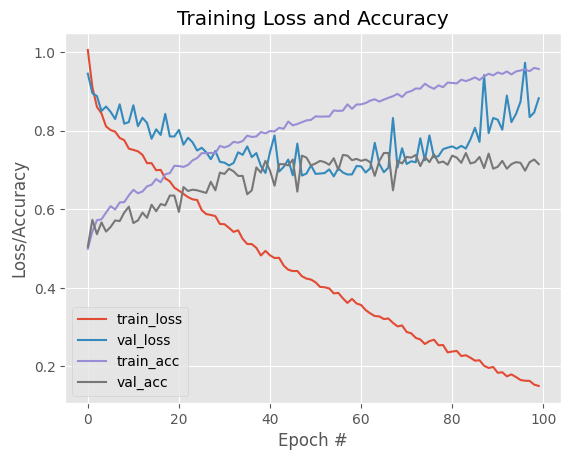

In [14]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# **ShallowNet on CIFAR-10**


In [25]:
class ShallowNetCif:
  def build(width,height,depth,classes):
    
    # initialize the model along with the input shape to be "channels last"
    model = Sequential()
    inputShape = (height,width,depth)

    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)

    # define the CONV => RELU layer
    model.add(Conv2D(32,3,input_shape=inputShape))
    model.add(Activation('relu'))
    model.add(Conv2D(64,3))
    model.add(Activation('relu'))
    model.add(Conv2D(128,3))
    model.add(Activation('relu'))
    #softmax classifier
    model.add(Flatten())
    model.add(Dense(classes))
    model.add(Activation('softmax'))

    #return the constructed network architecture
    return model

In [15]:
from keras.datasets import cifar10

In [17]:
# load the training and testing data, then scale it into the range [0, 1]
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer",
"dog", "frog", "horse", "ship", "truck"]

[INFO] loading CIFAR-10 data...


In [26]:
# initialize the optimizer and model
print("[INFO] compiling model...")
#opt = SGD(lr=0.01)
model = ShallowNetCif.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer='adam',
metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY),
batch_size=32, epochs=10, verbose=1)

[INFO] compiling model...
[INFO] training network...
Epoch 1/10
1563/1563 [==============================] - 14s 8ms/step - loss: 1.2977 - accuracy: 0.5419 - val_loss: 1.0979 - val_accuracy: 0.6169
Epoch 2/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.8972 - accuracy: 0.6909 - val_loss: 0.9415 - val_accuracy: 0.6772
Epoch 3/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6702 - accuracy: 0.7700 - val_loss: 0.9563 - val_accuracy: 0.6845
Epoch 4/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.4366 - accuracy: 0.8508 - val_loss: 1.1469 - val_accuracy: 0.6687
Epoch 5/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.2507 - accuracy: 0.9150 - val_loss: 1.3788 - val_accuracy: 0.6682
Epoch 6/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.1595 - accuracy: 0.9439 - val_loss: 1.7210 - val_accuracy: 0.6475
Epoch 7/10
1563/1563 [==============================] - 11s 7ms/step - loss: 

In [27]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

    airplane       0.70      0.64      0.67      1000
  automobile       0.81      0.79      0.80      1000
        bird       0.49      0.51      0.50      1000
         cat       0.40      0.43      0.42      1000
        deer       0.54      0.62      0.58      1000
         dog       0.56      0.49      0.52      1000
        frog       0.67      0.73      0.70      1000
       horse       0.71      0.66      0.68      1000
        ship       0.72      0.78      0.75      1000
       truck       0.80      0.69      0.74      1000

    accuracy                           0.63     10000
   macro avg       0.64      0.63      0.64     10000
weighted avg       0.64      0.63      0.64     10000



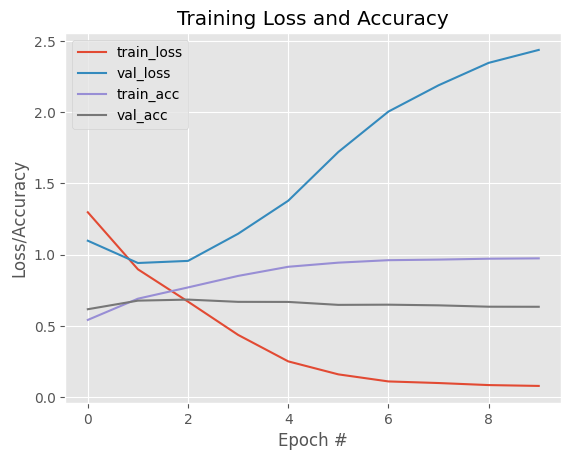

In [29]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 10), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 10), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 10), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 10), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()